In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

# 美股

## 2003~2009實驗 - 布林通道
- **稅前** OR **稅後** 5000萬或7500萬
- +當年度ROE出場
- 本益比進場條件
- 盈再率單獨調整
- 盈再率+ROE
- 盈再率+配息

## import

In [2]:
import talib
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from matplotlib.colors import ListedColormap

from dataframe import CustomDataFrame

import plot_data

In [3]:
# pd.options.display.float_format = '{:.4f}'.format # 禁用科學數字

## 日期設定

In [4]:
START_DATE = '2003-3-31'
END_DATE = '2009-3-31'

## 成分股比較

In [5]:
russell_1000_df = pd.read_csv('./russell_component_lists/russell_1000_company.csv')
russell_2000_df = pd.read_csv('./russell_component_lists/russell_2000_company.csv')
russell_3000_df = pd.read_csv('./russell_component_lists/russell_3000_company.csv')

russell_1000_symbol = russell_1000_df['Symbol'].to_list()
russell_2000_symbol = russell_2000_df['Symbol'].to_list()
russell_3000_symbol = russell_3000_df['Symbol'].to_list()

# Find elements only in russell_1000, or russell_2000, but not in russell_3000
only_russell_1000 = list(set(russell_1000_symbol) - set(russell_3000_symbol))
only_russell_2000 = list(set(russell_2000_symbol) - set(russell_3000_symbol))

print(only_russell_2000)
print(len(only_russell_2000))

# 結論 - 在羅素2000當中的公司不一定會在羅素3000

['AKYA', 'CBNK', 'EVEX', 'VALU', 'GAMB', 'GOCO', 'INFU', 'ALTI', 'CLPR', 'BDTX', 'QUIK', 'OVID', 'AFRI', 'RCKY', 'INBK', 'VSTM', 'ACHV', 'ATOS', 'CIX', 'RDZN', 'III', 'PVBC', 'BLZE', 'TAYD', 'PRPL', 'LFCR', 'PNRG', 'UP', 'BOLD', 'NREF', 'RXT', 'VERU', 'HBB', 'ABOS', 'ADCT', 'CTV', 'MG', 'BYRN', 'NNBR', 'PEBK', 'TLYS', 'EVI', 'FLXS', 'GUTS', 'PMTS', 'RSVR', 'NAUT', 'RELL', 'PYXS', 'BSVN', 'HSHP', 'AIRS', 'GEOS', 'CTGO', 'OPAD', 'FENC', 'CBUS', 'EEX', 'NKSH', 'BWFG', 'VLGEA', 'MYFW', 'APEI', 'ORN', 'BKSY', 'HNST', 'PDLB', 'PESI', 'IVVD', 'MHLD', 'RGTI', 'LFMD', 'TWIN', 'MFIN', 'VGAS', 'ELEV', 'DLHC', 'EGAN', 'RNGR', 'PKOH', 'TUSK', 'ISTR', 'JILL', 'TTSH', 'OBIO', 'NATR', 'NKTR', 'CTRN', 'GMGI', 'AQST', 'MLP', 'DTI', 'PLBC', 'LE', 'ACRV', 'FSTR', 'JSPR', 'VIRC', 'XOMA', 'SNDA', 'SWIM', 'NGVC', 'PTSI', 'ZURA', 'GCTS', 'ESSA', 'NTIC', 'CRD.A', 'FHTX', 'COOK', 'SEVN', 'AVAH', 'CRDF', 'PCB', 'KLTR', 'ATNM', 'HQI', 'RDW', 'METCB', 'CADL', 'CURV', 'STXS', 'RGCO', 'GLSI', 'PRCH', 'PCYO', 'ULBI',

## get data

In [6]:
data=Data(market='US')

---

---

## 資料下載

In [7]:
close = data.get('price:close')

### **盈餘再投資率**

In [8]:
netIncome = data.get('annual_report_fundamentals:netIncome')

# 4 年加總 #
bolling_1_filt = netIncome.copy()
# 提取index的月份
bolling_1_filt['month'] = bolling_1_filt.index.month
# 依據月份分組，對每個月份的每四年進行加總
result = bolling_1_filt.groupby('month', group_keys=False).apply(lambda group: group.rolling(4, min_periods=4).sum())
# result

# 刪除用來group的欄位
netprofit_rol = result.drop(columns='month')

In [9]:
# 去除稅後淨利為負 (計算盈再率)
adj_netprofit = netprofit_rol[(netprofit_rol > 0) & (netIncome > 0)]

In [10]:
# 長期投資
longTermInvestments = data.get('annual_report_fundamentals:longTermInvestments')
# 固定資產
propertyPlantEquipmentNet = data.get('annual_report_fundamentals:propertyPlantEquipmentNet')


capex = longTermInvestments + propertyPlantEquipmentNet
# 以月份為單位，所以要減掉 48 個月前的資料 (第四年 - 第0年)
capex_rol = capex.diff(48)


rr = capex_rol / adj_netprofit

In [11]:
# plot_data.numeric_bins(rr.resample("A-MAY").last(), '美股盈再率')

---

### **本益比 (P/E)**

In [12]:
pe = data.get('quarter_report:PE')

In [13]:
eps = data.get('quarter_report:EPS')

#### 每日本益比

In [14]:
eps_rol = eps + eps.shift(3) + eps.shift(6) + eps.shift(9) # 近四季加總
pe_daily = (close / eps_rol)
pe_daily = pe_daily[eps_rol > 0]

### **其他因子**

- ROE
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- ~~董監持股~~
- 上市上櫃滿兩年

In [15]:
roe = data.get('annual_report:ROE')

In [16]:
dpr = data.get('annual_report_fundamentals:dividendPayoutRatio')
# dpr

In [17]:
income_bf_tax = data.get('annual_report_fundamentals:incomeBeforeTax')

In [18]:
comp_profile = data.get('company_profile')
comp_profile

company_symbol                                    name   ipo_date  \
0                 A              Agilent Technologies, Inc. 1999-11-18   
1                AA                       Alcoa Corporation 2016-11-01   
2               AAL            American Airlines Group Inc. 2005-09-27   
3               AAN               The Aaron's Company, Inc. 2020-11-25   
4              AAON                              AAON, Inc. 1992-12-16   
...             ...                                     ...        ...   
2634           ZUMZ                             Zumiez Inc. 2005-05-06   
2635            ZUO                             Zuora, Inc. 2018-04-12   
2636            ZWS  Zurn Elkay Water Solutions Corporation 2012-03-29   
2637           ZYME                          Zymeworks Inc. 2017-04-28   
2638           ZYXI                             Zynex, Inc. 2004-02-25   

                                         industry  
0                Medical - Diagnostics & Research  
1                                        Aluminum  
2               Airlines, Airports & Air Services  
3                       Rental & Leasing Services  
4                                    Construction  
...                                           ...  
2634                             Apparel - Retail  
2635                    Software - Infrastructure  
2636  Industrial - Pollution & Treatment Controls  
2637                                Biotechnology  
2638                       Medical - Distribution  

[2639 rows x 4 columns]

In [19]:
stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date = row['ipo_date']
    end_date = listed_date + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed_df = pd.concat(stock_data, axis=1)

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 40%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [20]:
# ROE 5年平均 > 15%
roe_rol = roe.copy()
# 提取index的月份
roe_rol['month'] = roe_rol.index.month
# 依據月份分組，對每個月份的每5年計算平均
result = roe_rol.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
# 刪除用來group的欄位
roe_rol = result.drop(columns='month')

In [21]:
roe_cond = roe_rol > 0.15

In [22]:
rr_cond = rr < 0.4

In [23]:
netprofit_cond = netIncome > 75000000

In [24]:
bf_tax_cond = income_bf_tax > 75000000

In [25]:
payout_ratio = dpr[(netIncome > 0) & (dpr > 0)]


# 3 年至少 > 40%
bolling_1_filt = payout_ratio.copy()
# 提取index的月份
bolling_1_filt['month'] = bolling_1_filt.index.month
# 依據月份分組
result = bolling_1_filt.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min())
# 刪除用來group的欄位
payout_ratio_rol = result.drop(columns='month')

In [26]:
payout_cond = payout_ratio_rol >= 0.4

In [27]:
pe_cond_entry = pe < 12
pe_cond_exit = pe > 30

In [28]:
daily_pe_entry = (pe_daily.resample('M').last() < 12)[START_DATE:END_DATE]
daily_pe_exit = (pe_daily.resample('M').last() > 30)[START_DATE:END_DATE]

In [29]:
listed_cond = listed_df.resample('M').last()

---

# 回測

In [31]:
roe_cond_rep = backtest.sim(roe_cond[START_DATE:END_DATE], resample='M' , data=data)
roe_cond_rep.get_stats()

{'CAGR': 0.16722070121859844,
 'daily_sharpe': 18.62,
 'max_drawdown': -0.5388225214816141,
 'avg_drawdown': -0.05806915433984309,
 'win_ratio': 0.6458015267175573,
 'ytd': 0.08554723173632439}

In [32]:
rr_cond_rep = backtest.sim(rr_cond[START_DATE:END_DATE], resample='M', data=data)
rr_cond_rep.get_stats()

{'CAGR': 0.14829522437335352,
 'daily_sharpe': 21.66,
 'max_drawdown': -0.5417528559386732,
 'avg_drawdown': -0.061756510707181404,
 'win_ratio': 0.6303077522399688,
 'ytd': 0.053153796279119314}

In [33]:
# rr_cond_rep.calc_returns_contrib()

## 所有條件不含本益比進出場

In [30]:
orig_cond_opt = (rr_cond & roe_cond & netprofit_cond & payout_cond & listed_cond)[START_DATE:END_DATE]
orig_cond = ((rr < 0.8) & roe_cond & netprofit_cond & payout_cond & listed_cond)[START_DATE:END_DATE]
filtered_russell_1000_symbol = [symbol for symbol in russell_1000_symbol if symbol in close.columns]

In [31]:
filtered_russell_1000_symbol = [symbol for symbol in filtered_russell_1000_symbol if symbol not in ['ALAB', 'LOAR']]
# filtered_russell_1000_symbol

### 不看配息率

In [32]:
nodpr_cond_opt = (rr_cond & roe_cond & netprofit_cond & listed_cond)[START_DATE:END_DATE]
nodpr_cond_opt_filter = (rr_cond & roe_cond & netprofit_cond & listed_cond)[filtered_russell_1000_symbol][START_DATE:END_DATE]

## 所有條件包含本益比進出場

In [33]:
opt_orig_pe = (orig_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE])

opt_orig_pe_filt = (orig_cond_opt& daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol] 

### 不包含配息率

In [34]:
opt_noDPR_pe = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE])

opt_noDPR_pe_filt = (nodpr_cond_opt_filter & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt_filter) | daily_pe_exit[START_DATE:END_DATE])

---

---

## 大盤布林通道

In [35]:
us_benchmark = data.get('ruaindex:close')['2002':'2024-9']

In [36]:
upperband, middleband, lowerband = talib.BBANDS(us_benchmark.close, timeperiod=300, nbdevup=2.0, nbdevdn=2.0)

### 構建濾網

1. 第一次跌破下通道先記錄下來，等到下一次跌破而且到更低的收盤價賣出
2. 等回到均線之上再買入

In [37]:
# 創建一個買賣訊號的DataFrame，初始值全部為True
us_bollinger_signal_1 = pd.Series(True, index=us_benchmark.index)

# 記錄第一次跌破的價格
first_break_price = None
# 記錄是否已經回到lower band之上
crossed_above_lower = False
# 是否進入持續的 False 狀態直到突破中通道
in_selling_state = False

# 遍歷所有的日期
for date in us_benchmark.index:
    price = us_benchmark.close[date]
    lower = lowerband[date]
    middle = middleband[date]
    
    # 第一次跌破下通道
    if price < lower and first_break_price is None:
        first_break_price = price
        crossed_above_lower = False
    
    # 價格回到下通道之上
    elif price > lower:
        crossed_above_lower = True
    
    # 再次跌破下通道且符合賣出條件
    if price < lower and crossed_above_lower and price < first_break_price:

        # print(f'{date} - {price} - {lower} - {first_break_price}')
        
        us_bollinger_signal_1[date] = False
        in_selling_state = True
    
    # 突破中通道則重置狀態
    if price > middle:
        us_bollinger_signal_1[date] = True
        first_break_price = None
        crossed_above_lower = False
        in_selling_state = False
    
    # 在突破中通道之前保持賣出狀態
    if in_selling_state and price <= middle:
        us_bollinger_signal_1[date] = False

In [38]:
# lowerband['2015-8-20':'2015-9-30']

In [39]:
# us_benchmark['2015-8-20':'2015-9-30']

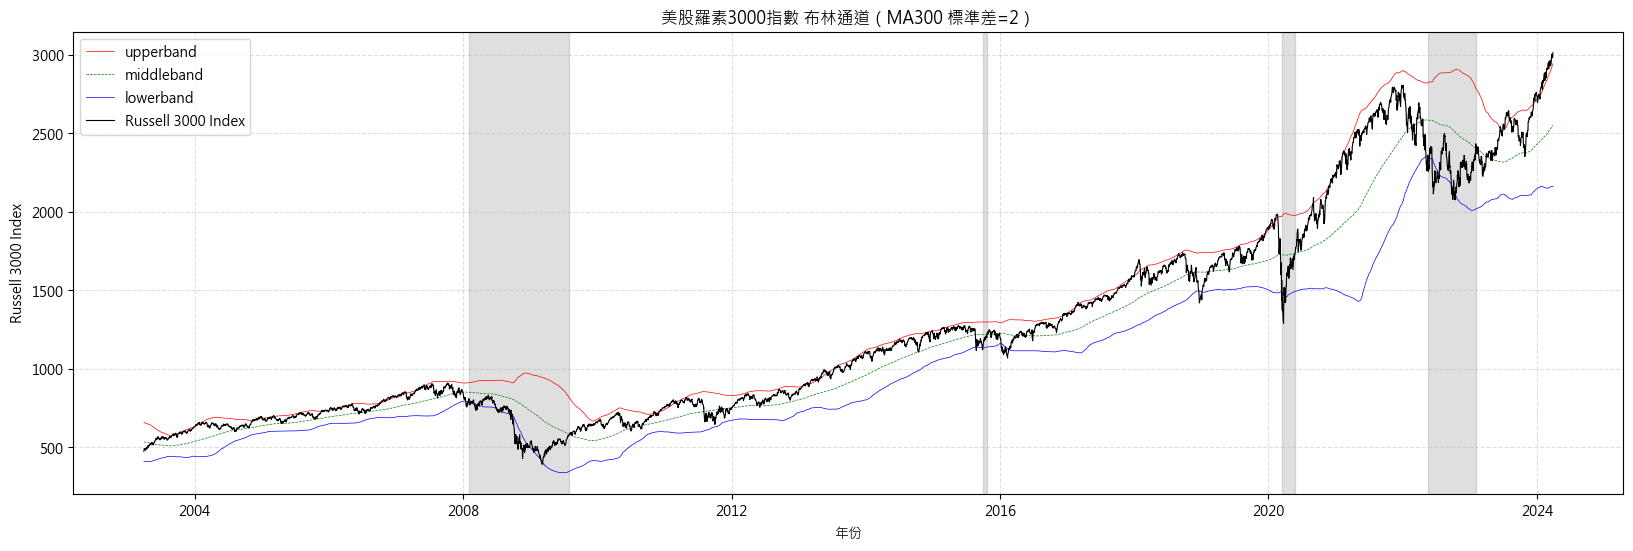

In [40]:
plt.figure(figsize=(20, 6))

plt.plot(upperband['2003-3-31':'2024-3-31'],
         label="upperband",color='r',
         linestyle='solid', linewidth=0.5)
plt.plot(middleband['2003-3-31':'2024-3-31'],
         label="middleband",color='g',linestyle='--', linewidth=0.5)
plt.plot(lowerband['2003-3-31':'2024-3-31'],
         label="lowerband",color='b',
         linestyle='solid', linewidth=0.5)
plt.plot(us_benchmark['2003-3-31':'2024-3-31'],
         label="Russell 3000 Index",color='black', linewidth=0.8)

plt.title("美股羅素3000指數 布林通道（MA300 標準差=2）") 
plt.xlabel("年份") 
plt.ylabel("Russell 3000 Index")

# 添加背景顏色
plt.axvspan(pd.Timestamp('2008-2-5'), pd.Timestamp('2009-7-31'), color='gray', alpha=0.25)
plt.axvspan(pd.Timestamp('2015-9-28'), pd.Timestamp('2015-10-23'), color='gray', alpha=0.25)
plt.axvspan(pd.Timestamp('2020-3-16'), pd.Timestamp('2020-5-26'), color='gray', alpha=0.25)
plt.axvspan(pd.Timestamp('2022-5-18'), pd.Timestamp('2023-2-2'), color='gray', alpha=0.25)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [41]:
bolling_1_filt = orig_cond_opt.copy()

# 將 df 的 index 對齊 us_bollinger_signal_1 的 index，並填充為 True，這樣可以保證日期範圍內的所有日期都包括
aligned_signal = us_bollinger_signal_1.reindex(bolling_1_filt.index, method='ffill', fill_value=True)

# 將 df 中日期對應的行設置為 aligned_signal 的值
bolling_1_filt.loc[aligned_signal.index, :] = aligned_signal.values[:, None]

In [42]:
# bolling_1_filt.to_csv('./performance_file/US/test_bollinger_trade_signal_1.csv')

---

## 全部比較

In [43]:
# bf_tax_cond = income_bf_tax > 75000000
orig_cond_bft = rr_cond & roe_cond & bf_tax_cond & payout_cond & listed_cond
nodpr_bft_cond = rr_cond & roe_cond & bf_tax_cond & listed_cond


overall_conds = {}

# overall_conds['所有條件_盈再率<80_無本益比'] = orig_cond
overall_conds['所有條件_無本益比'] = orig_cond_opt
# overall_conds['所有條件_無本益比_稅前淨利'] = orig_cond_bft[START_DATE:END_DATE]
overall_conds['所有條件_無本益比_羅素1000'] = orig_cond_opt[filtered_russell_1000_symbol]
overall_conds['所有條件_無本益比_羅素1000_布林通道'] = (orig_cond_opt[filtered_russell_1000_symbol] & bolling_1_filt)[START_DATE:END_DATE]
# overall_conds['所有條件_無本益比_稅前淨利_羅素1000'] = orig_cond_bft[START_DATE:END_DATE][filtered_russell_1000_symbol]
overall_conds['所有條件_無本益比_布林通道'] = orig_cond_opt & bolling_1_filt
overall_conds['所有條件_無本益比_ROE出場條件'] = orig_cond_opt & (roe[START_DATE:END_DATE] > 0.15)
overall_conds['所有條件_無本益比_ROE出場條件_布林通道'] = orig_cond_opt & bolling_1_filt & (roe[START_DATE:END_DATE] > 0.15)
overall_conds['所有條件_無本益比_ROE出場條件_羅素1000'] = (orig_cond_opt & (roe[START_DATE:END_DATE] > 0.15))[filtered_russell_1000_symbol]
overall_conds['所有條件_無本益比_ROE出場條件_羅素1000_布林通道'] = (orig_cond_opt & bolling_1_filt & (roe[START_DATE:END_DATE] > 0.15))[filtered_russell_1000_symbol]

# overall_conds['所有條件_盈再率<80_每季本益比'] = orig_quarter_pe
overall_conds['所有條件_有本益比'] = opt_orig_pe
overall_conds['所有條件_有本益比_ROE出場條件'] = (orig_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15))
overall_conds['所有條件_有本益比_布林通道'] = (orig_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | ~bolling_1_filt)
overall_conds['所有條件_有本益比_ROE出場條件_布林通道'] = (orig_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15) | ~bolling_1_filt)
overall_conds['所有條件_有本益比_ROE出場條件_羅素1000_布林通道'] = (orig_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15) | ~bolling_1_filt)[filtered_russell_1000_symbol]


# overall_conds['所有條件_有本益比_稅前淨利'] = (orig_cond_bft[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_bft[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])
overall_conds['所有條件_有本益比_羅素1000'] = opt_orig_pe_filt
overall_conds['所有條件_有本益比_羅素1000_布林通道'] = (orig_cond_opt& daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | ~bolling_1_filt)[filtered_russell_1000_symbol]
overall_conds['所有條件_有本益比_ROE出場條件_羅素1000'] = (orig_cond_opt& daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15))[filtered_russell_1000_symbol] 
# overall_conds['所有條件_有本益比_稅前淨利_羅素1000'] = (orig_cond_bft[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_bft[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol]

# # overall_conds['去掉配息盈再率<80_無本益比'] = test_cond
# overall_conds['去掉配息_無本益比'] = nodpr_cond_opt
# # overall_conds['去掉配息_無本益比_稅前淨利'] = nodpr_bft_cond[START_DATE:END_DATE]
# overall_conds['去掉配息_無本益比_羅素1000'] = nodpr_cond_opt_filter
# # overall_conds['去掉配息_無本益比_稅前淨利_羅素1000'] = nodpr_bft_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]
# # overall_conds['去掉配息_盈再率<80_每季本益比'] = test_noDPR_pe
# overall_conds['去掉配息_無本益比_布林通道'] = nodpr_cond_opt & bolling_1_filt

# overall_conds['去掉配息_有本益比'] = opt_noDPR_pe
# overall_conds['去掉配息_有本益比_ROE出場條件'] = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15))
# # overall_conds['去掉配息_有本益比_稅前淨利'] = (nodpr_bft_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_bft_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])
# overall_conds['去掉配息_有本益比_布林通道'] = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | ~bolling_1_filt)
# overall_conds['去掉配息_有本益比_布林通道_ROE出場條件'] = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15) | ~bolling_1_filt)

# overall_conds['去掉配息_有本益比_羅素1000'] = opt_noDPR_pe_filt
# overall_conds['去掉配息_有本益比_羅素1000_ROE出場條件'] = (nodpr_cond_opt_filter & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt_filter) | daily_pe_exit[START_DATE:END_DATE] | (roe[START_DATE:END_DATE] < 0.15))
# # overall_conds['去掉配息_有本益比_稅前淨利_羅素1000'] = (nodpr_bft_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_bft_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol]


# overall_conds['單一條件_ROE五年平均'] = roe_cond[START_DATE:END_DATE]
# # overall_conds['單一條件_ROE五年平均_布林通道'] = roe_cond[START_DATE:END_DATE] & bolling_1_filt
# overall_conds['單一條件_ROE五年平均_羅素1000'] = roe_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]

# overall_conds['單一條件_盈再率<40%'] = rr_cond[START_DATE:END_DATE]
# overall_conds['單一條件_盈再率<40%_羅素1000'] = rr_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]
# # overall_conds['單一條件_盈再率<80%'] = (rr<0.8)[START_DATE:END_DATE]


overall_conds_collecs = sim_conditions(overall_conds, resample='M', data=data)
overall_conds_collecs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 16/16 [00:13<00:00,  1.18condition/s]


CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%  \
Strategy                                                                     
所有條件_有本益比_ROE出場條件_羅素1000_布林通道     11.69   -13.61    8.62  10.0   7.0  13.0   
所有條件_無本益比_ROE出場條件_羅素1000_布林通道     10.28   -13.17   10.79  12.0   8.0  16.0   
所有條件_有本益比_羅素1000_布林通道             10.12   -12.77   10.48  12.0  11.0  15.0   
所有條件_有本益比_ROE出場條件_布林通道             9.37   -13.37    9.42  11.0   8.0  14.0   
所有條件_無本益比_羅素1000_布林通道              8.99   -12.52   12.97  14.0  13.0  18.0   
所有條件_無本益比_ROE出場條件_布林通道             8.47   -12.81   11.60  13.0   9.0  17.0   
所有條件_有本益比_布林通道                     8.40   -13.40   11.62  13.0  12.0  16.0   
所有條件_無本益比_布林通道                     7.67   -13.00   14.11  15.0  14.0  20.0   
所有條件_有本益比_ROE出場條件_羅素1000           4.78   -47.88   12.37  12.0   9.0  14.0   
所有條件_無本益比_ROE出場條件_羅素1000           4.03   -45.81   15.12  15.0  12.0  18.0   
所有條件_有本益比_羅素1000                   2.78   -50.26   14.59  14.0  11.0  15.0   
所有條件_無本益比_羅素1000                   2.13   -49.98   17.70  17.0  14.0  20.0   
所有條件_有本益比_ROE出場條件                  2.09   -50.62   13.86  13.0  10.0  15.0   
所有條件_無本益比_ROE出場條件                  1.79   -48.60   16.62  16.0  13.0  19.0   
所有條件_有本益比                          0.82   -53.11   16.56  15.0  12.0  18.0   
所有條件_無本益比                          0.53   -52.54   19.67  18.0  15.0  23.0   

                                Min   Max  
Strategy                                   
所有條件_有本益比_ROE出場條件_羅素1000_布林通道   0.0  14.0  
所有條件_無本益比_ROE出場條件_羅素1000_布林通道   0.0  19.0  
所有條件_有本益比_羅素1000_布林通道           0.0  16.0  
所有條件_有本益比_ROE出場條件_布林通道          0.0  15.0  
所有條件_無本益比_羅素1000_布林通道           0.0  20.0  
所有條件_無本益比_ROE出場條件_布林通道          0.0  20.0  
所有條件_有本益比_布林通道                  0.0  19.0  
所有條件_無本益比_布林通道                  0.0  23.0  
所有條件_有本益比_ROE出場條件_羅素1000        7.0  22.0  
所有條件_無本益比_ROE出場條件_羅素1000        8.0  24.0  
所有條件_有本益比_羅素1000               10.0  24.0  
所有條件_無本益比_羅素1000               13.0  26.0  
所有條件_有本益比_ROE出場條件               8.0  26.0  
所有條件_無本益比_ROE出場條件               9.0  28.0  
所有條件_有本益比                      11.0  29.0  
所有條件_無本益比                      14.0  31.0

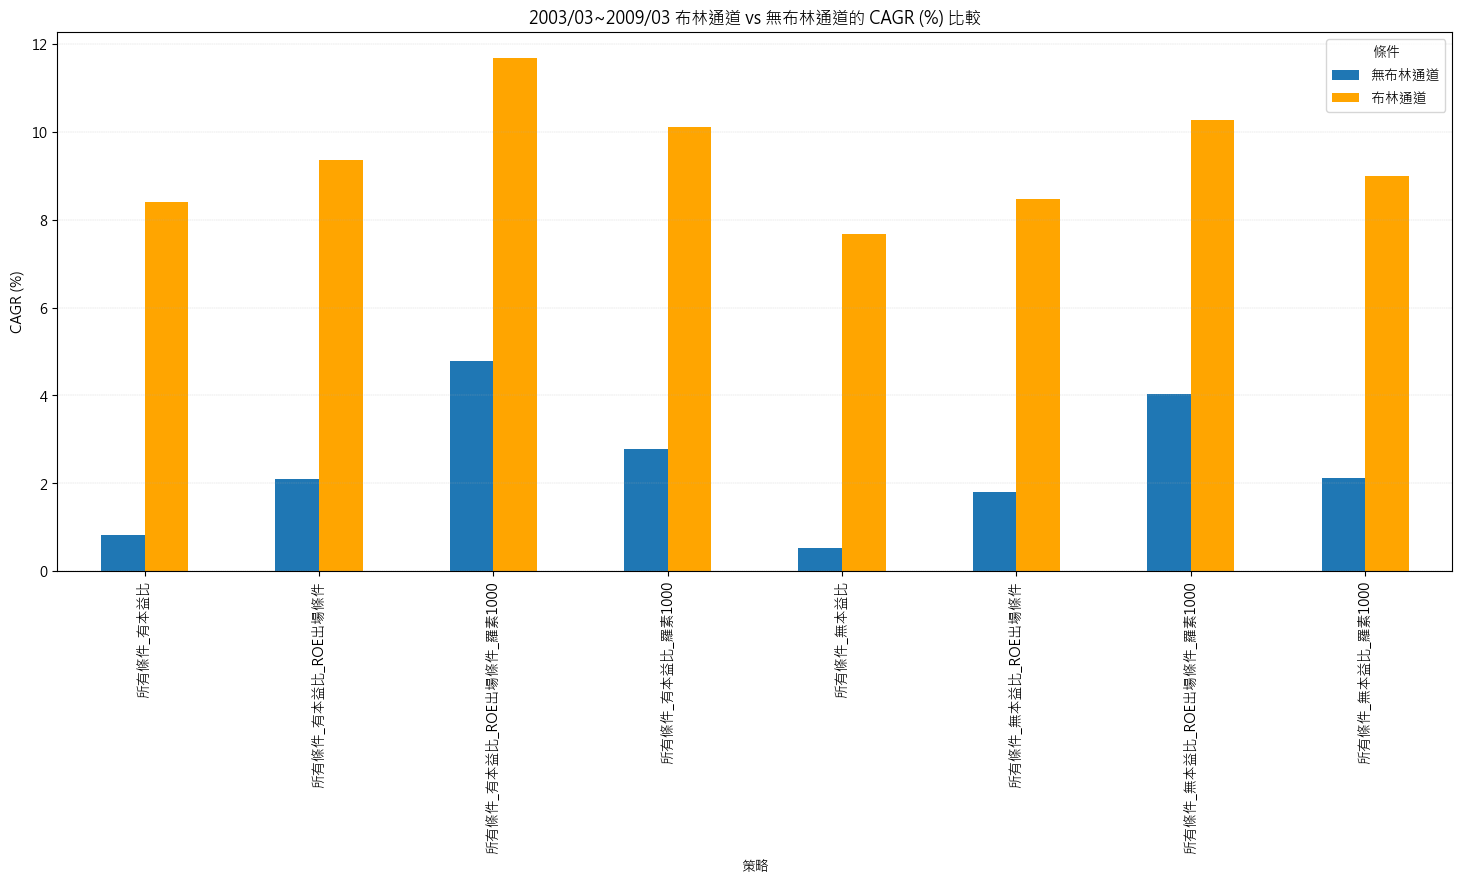

In [44]:
df = overall_conds_collecs.selected_stock_count_analysis().reset_index()

# 提取策略前綴，移除 '_布林通道' 作為分組依據
df["Base_Strategy"] = df["Strategy"].str.replace("_布林通道", "", regex=False)
df["Condition"] = df["Strategy"].str.contains("_布林通道")  # 判斷是否包含 '_布林通道'

# 計算有無布林通道的績效差異
comparison_df = df.pivot_table(
    index="Base_Strategy",  # 使用策略前綴作為索引
    columns="Condition",
    values="CAGR (%)"
)

# 調整列名，便於圖表呈現
comparison_df.columns = ["無布林通道", "布林通道"]
comparison_df = comparison_df.reset_index()

# 繪製條形圖
ax = comparison_df.plot(
    x="Base_Strategy",
    kind="bar",
    figsize=(18, 7),
    title="2003/03~2009/03 布林通道 vs 無布林通道的 CAGR (%) 比較",
    ylabel="CAGR (%)",
    xlabel="策略",
    rot=90,
    color=['tab:blue', 'orange']
)

# 調整圖例
plt.legend(["無布林通道", "布林通道"], title="條件")
# plt.tight_layout()
plt.grid(axis='y', alpha=0.6, linestyle='--', linewidth=0.3)
plt.show()

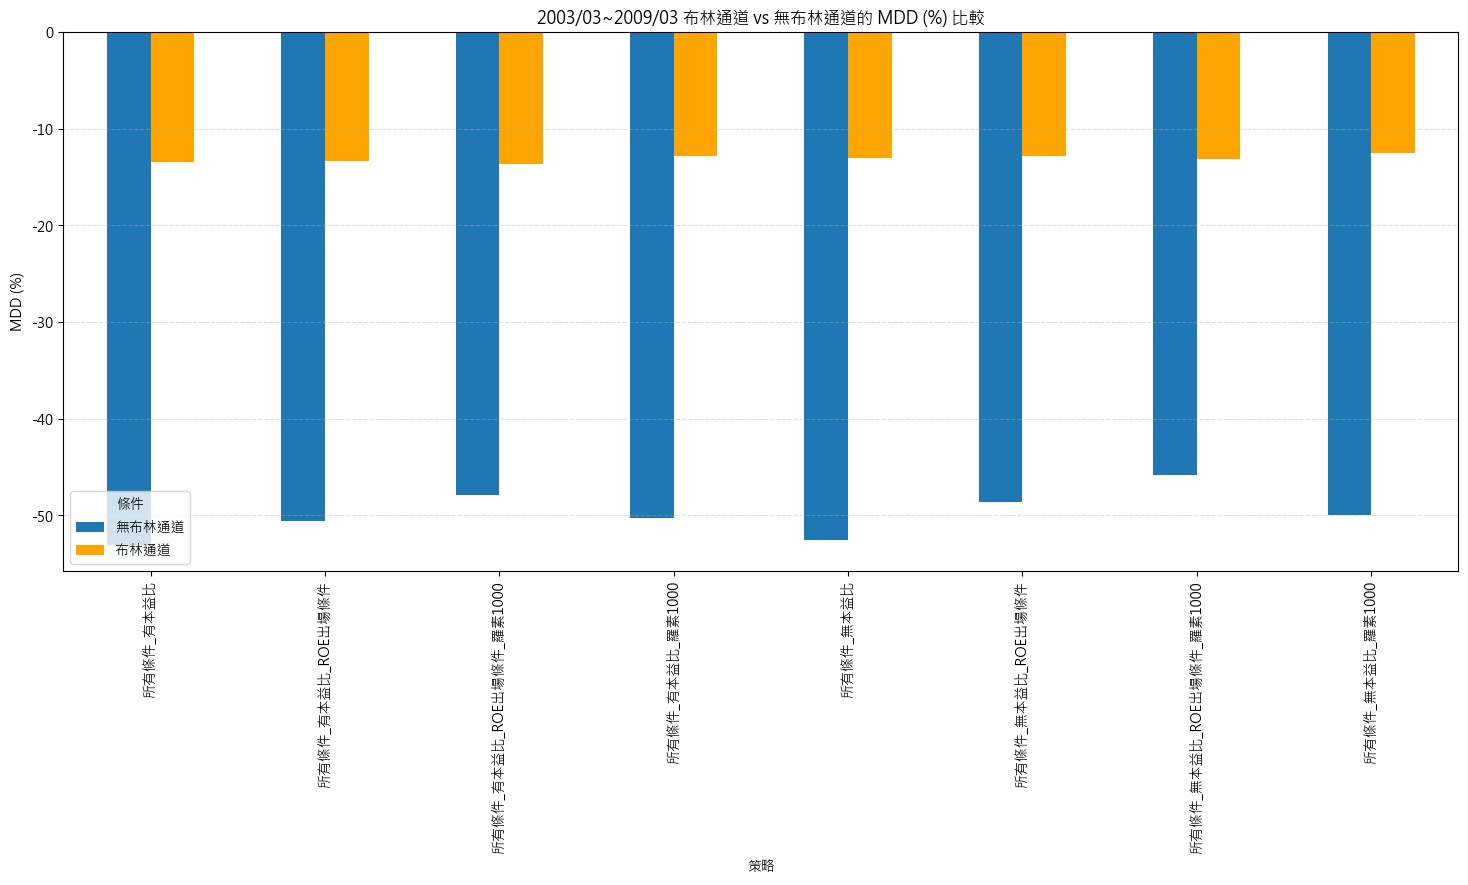

In [45]:
# 提取策略前綴，移除 '_布林通道' 作為分組依據
df["Base_Strategy"] = df["Strategy"].str.replace("_布林通道", "", regex=False)
df["Condition"] = df["Strategy"].str.contains("_布林通道")  # 判斷是否包含 '_布林通道'

# 計算有無布林通道的績效差異
comparison_df = df.pivot_table(
    index="Base_Strategy",  # 使用策略前綴作為索引
    columns="Condition",
    values="MDD (%)"
)

# 調整列名，便於圖表呈現
comparison_df.columns = ["無布林通道", "布林通道"]
comparison_df = comparison_df.reset_index()

# 繪製條形圖
ax = comparison_df.plot(
    x="Base_Strategy",
    kind="bar",
    figsize=(18, 7),
    title="2003/03~2009/03 布林通道 vs 無布林通道的 MDD (%) 比較",
    ylabel="MDD (%)",
    xlabel="策略",
    rot=90,
    color=['tab:blue', 'orange']
)

# 調整圖例
plt.legend(["無布林通道", "布林通道"], title="條件")
# plt.tight_layout()
plt.grid(axis='y', alpha=0.4, linestyle='--')
plt.show()

In [48]:
overall_conds_collecs.holding_period_analysis()

CAGR (%)  MDD (%)       持有期間平均     25%    中位數  \
Strategy                                                                       
所有條件_有本益比_ROE出場條件_羅素1000_布林通道     12.35   -37.97   701.934426  213.00  397.0   
所有條件_有本益比_ROE出場條件_羅素1000          12.12   -47.88  1086.815789  365.00  638.5   
所有條件_無本益比_羅素1000                  11.86   -49.98  1299.234146  366.00  733.0   
所有條件_有本益比_ROE出場條件                 11.73   -50.62   915.956522  365.00  398.0   
所有條件_無本益比_ROE出場條件                 11.57   -48.60  1032.303030  365.00  701.0   
所有條件_有本益比_ROE出場條件_布林通道            11.45   -37.20   601.304094  212.00  366.0   
所有條件_無本益比_ROE出場條件_羅素1000_布林通道     11.24   -37.42   636.322785  335.75  393.0   
所有條件_有本益比_羅素1000                  11.07   -50.26  1070.218045  334.00  580.0   
所有條件_無本益比                         11.00   -52.54  1115.416370  365.00  727.0   
所有條件_有本益比                         10.95   -53.11   911.846561  336.00  394.0   
所有條件_有本益比_布林通道                    10.39   -38.86   584.966019  189.50  365.0   
所有條件_無本益比_ROE出場條件_布林通道            10.13   -39.12   588.735000  274.00  393.0   
所有條件_無本益比_布林通道                     9.72   -38.83   627.222989  334.00  393.0   

                                   75%   最大值  最小值  
Strategy                                           
所有條件_有本益比_ROE出場條件_羅素1000_布林通道   943.75  2221   61  
所有條件_有本益比_ROE出場條件_羅素1000       1331.00  5657   61  
所有條件_無本益比_羅素1000               1793.00  7667   31  
所有條件_有本益比_ROE出場條件              1066.00  5657   59  
所有條件_無本益比_ROE出場條件              1126.00  7667   28  
所有條件_有本益比_ROE出場條件_布林通道          716.00  2221   30  
所有條件_無本益比_ROE出場條件_羅素1000_布林通道   731.00  2221   28  
所有條件_有本益比_羅素1000               1338.00  5657   31  
所有條件_無本益比                      1457.00  7667   31  
所有條件_有本益比                      1066.00  5657   31  
所有條件_有本益比_布林通道                  722.75  2221   30  
所有條件_無本益比_ROE出場條件_布林通道          700.25  2221   28  
所有條件_無本益比_布林通道                  731.00  2221   31

In [49]:
# rep_all_cond_MDD = rep_all_cond.calc_dd(rep_all_cond.stock_data['portfolio_returns'])*100
rep_all_cond_and_pe_MDD = overall_conds_collecs.reports['所有條件_有本益比'].calc_dd(overall_conds_collecs.reports['所有條件_有本益比'].stock_data['portfolio_returns'])*100
rep_all_cond_and_pe_bolling_MDD = overall_conds_collecs.reports['所有條件_有本益比_布林通道'].calc_dd(overall_conds_collecs.reports['所有條件_有本益比_布林通道'].stock_data['portfolio_returns'])*100
benchmark_MDD = overall_conds_collecs.reports['所有條件_有本益比_布林通道'].calc_dd(overall_conds_collecs.reports['所有條件_有本益比_布林通道'].benchmark.close['2003-3-31':])*100

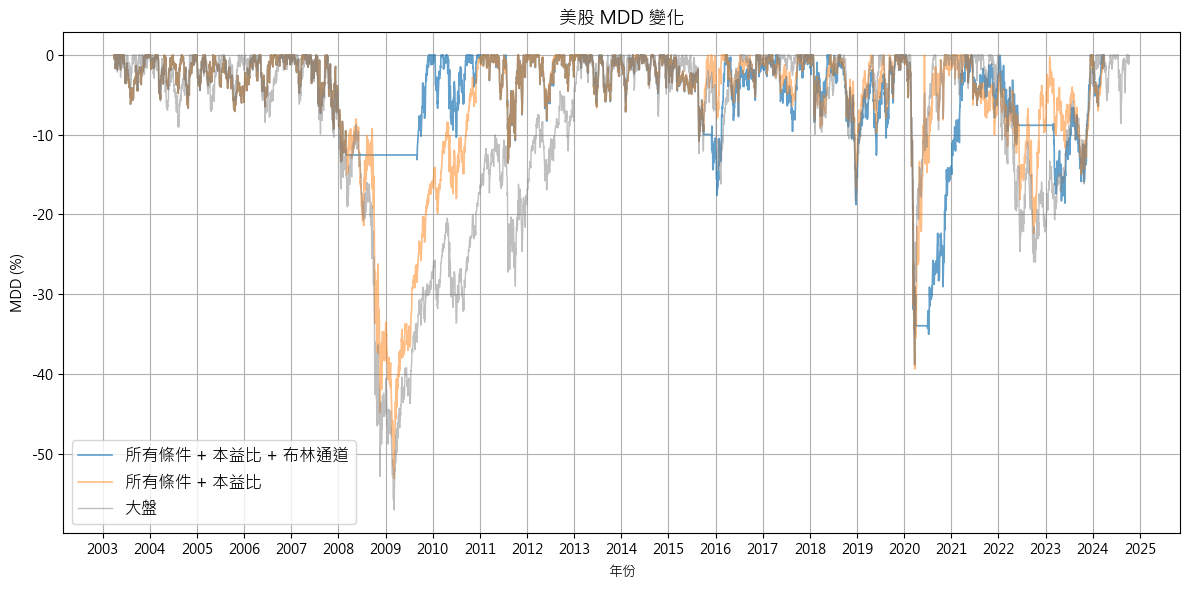

In [59]:
plt.figure(figsize=(12, 6))

plt.plot(rep_all_cond_and_pe_bolling_MDD.index, rep_all_cond_and_pe_bolling_MDD.values, label='所有條件 + 本益比 + 布林通道', alpha=0.7, linewidth=1.2)
plt.plot(rep_all_cond_and_pe_MDD.index, rep_all_cond_and_pe_MDD.values, label='所有條件 + 本益比', alpha=0.5, linewidth=1.2)
plt.plot(benchmark_MDD.index, benchmark_MDD.values, label='大盤', alpha=0.5, linewidth=1, color='gray')

plt.title('美股 MDD 變化', fontsize=13)
plt.xlabel('年份')
plt.ylabel('MDD (%)')

plt.legend(fontsize=12)
plt.grid()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

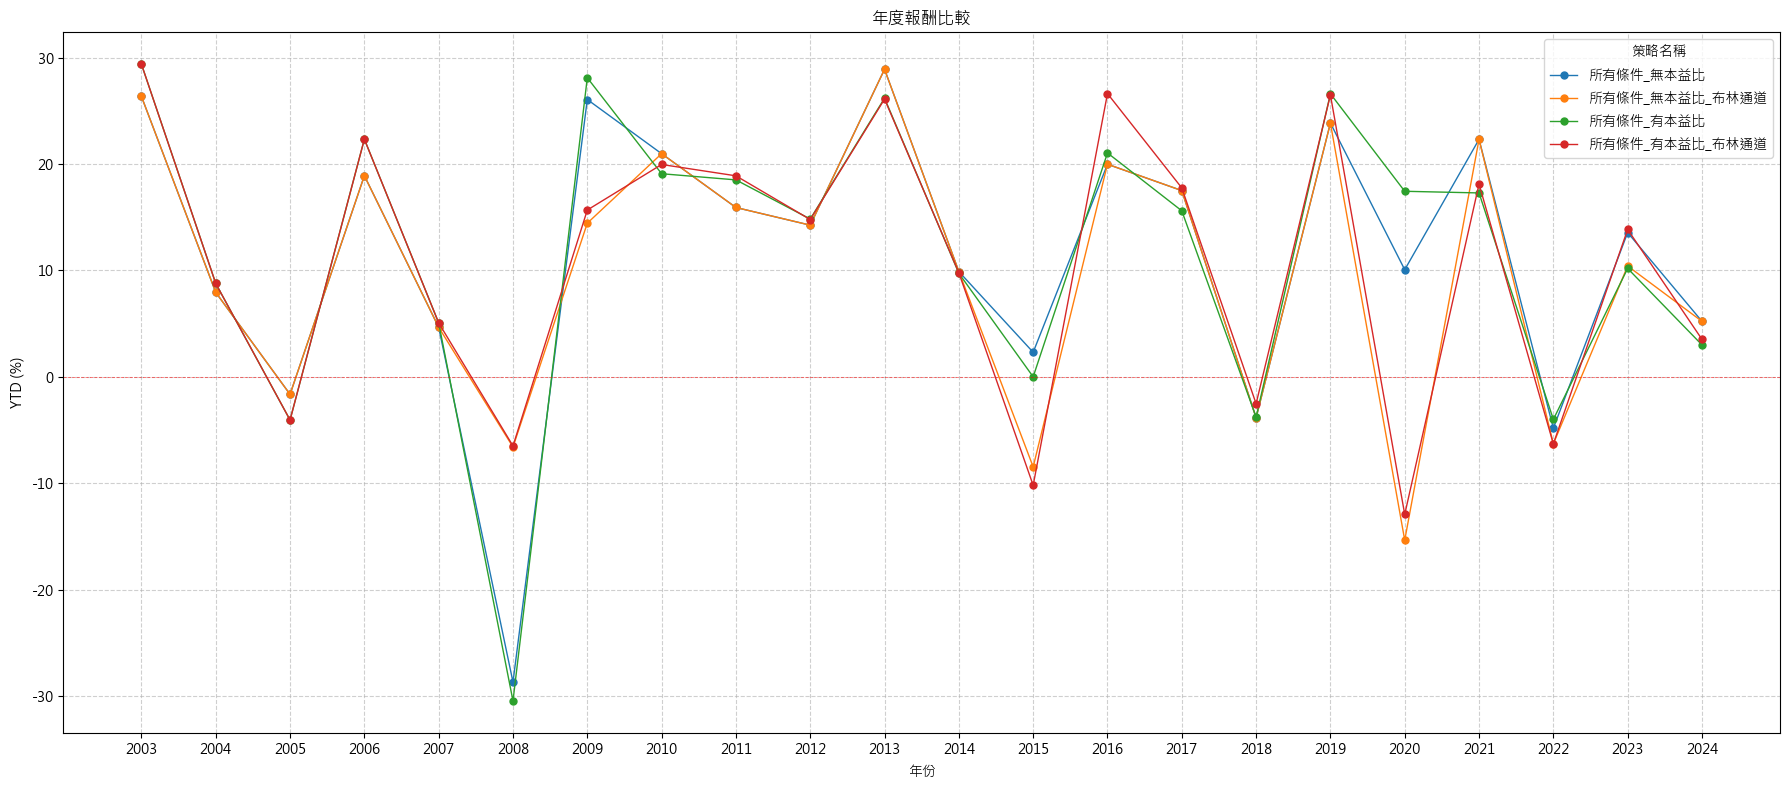

In [51]:
# def visualize_ytd_performance(rep_collecs, selected_strategies=None):
#     """
#     可視化指定策略的逐年YTD報酬。

#     參數:
#         rep_collecs: 包含策略數據的資料結構。
#         selected_strategies: 要視覺化的策略名稱列表，若為None則顯示所有策略。

#     回傳:
#         無 (直接顯示圖表)
#     """
#     strategy_names = list(rep_collecs.reports.keys())
#     if selected_strategies:
#         strategy_names = [strategy for strategy in strategy_names if strategy in selected_strategies]
    
#     yearly_ytd = {}

#     # 收集所有年份的數據
#     for strategy in strategy_names:
#         for year, values in rep_collecs.reports[strategy].return_table.items():
#             if year not in yearly_ytd:
#                 yearly_ytd[year] = {}
#             yearly_ytd[year][strategy] = values['YTD'] * 100  # 轉換為百分比

#     # 準備繪圖
#     plt.figure(figsize=(18, 8))
#     years = sorted(yearly_ytd.keys())

#     for strategy in strategy_names:
#         ytd_values = [yearly_ytd[year].get(strategy, None) for year in years]
#         plt.plot(years, ytd_values, label=strategy, marker='o', markersize=5, linewidth=1)

#     # 設置圖表屬性
#     plt.xticks(years)
#     plt.axhline(y=0, color='r', linestyle='--', linewidth=0.6, alpha=0.6)
#     plt.title('年度報酬比較')
#     plt.xlabel('年份')
#     plt.ylabel('YTD (%)')
#     plt.legend(title='策略名稱')
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.tight_layout()

#     # 顯示圖表
#     plt.show()


# 測試函數 (可以傳入策略名稱的列表來篩選)
overall_conds_collecs.visualize_ytd_performance(selected_strategies=['所有條件_無本益比', '所有條件_有本益比', '所有條件_無本益比_布林通道', '所有條件_有本益比_布林通道'])


In [52]:
overall_conds_collecs.reports['所有條件_無本益比_布林通道'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     9.72%  30.34      -38.83%    65.44%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
HNI      2023-04-03 2023-06-01     2023-03-31    2023-05-31  0.016949      41   
VFC      2023-03-01 2023-07-03     2023-02-28    2023-06-30  0.017857      85   
NTAP     2023-03-01 2023-08-01     2023-02-28    2023-07-31  0.017857     105   
ADP      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
AFG      2023-04-03        NaT     2023-03-31           NaT  0.016949     384   
AMCR     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
AMGN     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
APAM     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
AVGO     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
BKE      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
BR       2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
CLX      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
CNA      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
CNS      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
CPB      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
CSCO     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
ECL      2023-04-03        NaT     2023-03-31           NaT  0.016949     384   
EXPO     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
EXR      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
FAST     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
GILD     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
GIS      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
GLPI     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
GRMN     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
HON      2023-04-03        NaT     2023-03-31           NaT  0.016949     384   
HSY      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
HUBB     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
IBM      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
IPG      2023-04-03        NaT     2023-03-31           NaT  0.016949     384   
ITW      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
JNJ      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
K        2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
KO       2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
KTB      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
LEG      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
LLY      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
LMT      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
MC       2023-04-03        NaT     2023-03-31           NaT  0.016949     384   
MKC      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
MMM      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
MRK      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
MSM      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
NUS      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
OMC      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
OMF      2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
PAX      2023-04-03        NaT     2023-03-31           NaT  0.016949     384   
PAYX     2023-03-01        NaT     2023-02-28           NaT  0.017857     407   
PEP      2023-03-01        NaT     2023-

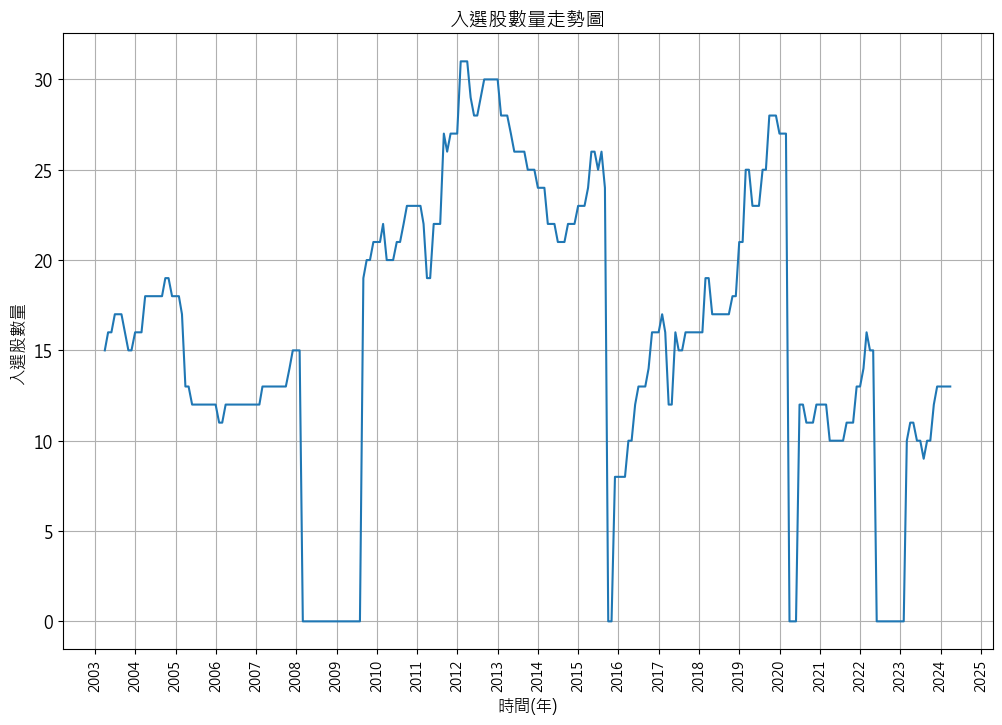

In [53]:
overall_conds_collecs.reports['所有條件_有本益比_布林通道'].plot_company_counts()

In [54]:
# _,_=overall_conds_collecs.reports['所有條件_有本益比_布林通道'].calc_returns_contrib()

In [55]:
overall_conds_collecs.reports['所有條件_有本益比'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    10.95%  24.59      -53.11%    68.64%

entry_date exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                       
AFG      2023-04-03       NaT     2023-03-31           NaT  0.050000     384   
AMCR     2023-11-01       NaT     2023-10-31           NaT  0.052632     237   
APAM     2022-04-01       NaT     2022-03-31           NaT  0.055556     635   
BKE      2022-06-01       NaT     2022-05-31           NaT  0.052632     594   
CNA      2022-04-01       NaT     2022-03-31           NaT  0.055556     635   
CPB      2020-12-01       NaT     2020-11-30           NaT  0.043478     971   
CSCO     2020-12-01       NaT     2020-11-30           NaT  0.043478     971   
GIS      2008-10-01       NaT     2008-09-30           NaT  0.037037    4034   
IPG      2023-11-01       NaT     2023-10-31           NaT  0.052632     237   
JNJ      2023-12-01       NaT     2023-11-30           NaT  0.050000     216   
K        2018-05-01       NaT     2018-04-30           NaT  0.038462    1623   
KTB      2022-06-01       NaT     2022-05-31           NaT  0.052632     594   
LEG      2016-10-03       NaT     2016-09-30           NaT  0.037037    2019   
LMT      2021-12-01       NaT     2021-11-30           NaT  0.055556     719   
MMM      2019-06-03       NaT     2019-05-31           NaT  0.038462    1350   
OMC      2017-09-01       NaT     2017-08-31           NaT  0.037037    1788   
OMF      2022-04-01       NaT     2022-03-31           NaT  0.055556     635   
PSA      2022-12-01       NaT     2022-11-30           NaT  0.047619     467   
SCCO     2022-07-01       NaT     2022-06-30           NaT  0.050000     573   
VIRT     2023-04-03       NaT     2023-03-31           NaT  0.050000     384   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
AFG              5850          -1  0.180330 -0.117544  0.214417  0.018569   
AMCR             5997          -1  0.330580  0.000000  0.370773  0.000000   
APAM             5599          -1  0.278666 -0.319052  0.377089  0.046187   
BKE              5640          -1  0.540604 -0.168051  0.685045  0.002266   
CNA              5599          -1  0.151561 -0.253471  0.243418  0.004308   
CPB              5263          -1  0.071374 -0.179928  0.221067  0.056962   
CSCO             5263          -1  0.379206 -0.042553  0.511936  0.511936   
GIS              2200          -1  2.414592 -0.317483  3.162824  0.000000   
IPG              5997          -1  0.131912  0.000000  0.191544  0.000000   
JNJ              6018          -1  0.027221 -0.081034  0.081616  0.035347   
K                4611          -1  0.836824 -0.081862  0.853015  0.294657   
KTB              5640          -1  1.182768 -0.194993  1.284562  0.015577   
LEG              4215          -1 -0.621094 -0.686485  0.495250  0.495250   
LMT              5515          -1  0.945649  0.000000  0.990213  0.000000   
MMM              4884          -1  0.226084 -0.365935  0.380569  0.380569   
OMC              4446          -1  0.815884 -0.285586  0.855861  0.258122   
OMF              5599          -1  0.191738 -0.366342  0.368185  0.038978   
PSA              5767          -1  0.242912 -0.162992  0.336935  0.081130   
SCCO             5661          -1  1.580252 -0.132206  1.843757  0.041398   
VIRT             5850          -1  0.860273 -0.087842  0.886562  0.182664   

               mdd   pdays  weight  next_weights  
stock_id                                          
AFG      -0.133631   216.0    0.05          0.05  
AMCR     -0.098101   236.0    0.05          0.05  
APAM     -0.349114   335.0    0.05          0.05  
BKE      -0.336138   543.0    0.05          0.05  
CNA      -0.256673   175.0    0.05          0.05  
CPB      -0.318030   376.0    0.05          0.05  
CSCO     -0.366741   955.0    0.05          0.05  
GIS      -0.450980  3747.0    0.05          0.05  
IPG      -0.142240   236.0    0.05         

In [56]:
orig_conds_compare = {}

# overall_conds['所有條件_盈再率<80_無本益比'] = orig_cond
orig_conds_compare['所有條件_無本益比'] = orig_cond_opt
orig_conds_compare['所有條件_無本益比_布林通道'] = orig_cond_opt & bolling_1_filt

orig_conds_compare['所有條件_有本益比'] = opt_orig_pe
orig_conds_compare['所有條件_有本益比_布林通道'] = (orig_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE] | ~bolling_1_filt)



orig_conds_collecs = sim_conditions(orig_conds_compare, resample='M', data=data)

Backtesting progress: 100%|██████████| 4/4 [00:06<00:00,  1.74s/condition]


In [57]:
orig_conds_collecs.reports['所有條件_有本益比_布林通道'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    10.39%  28.75      -38.86%    66.32%

entry_date exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                       
AFG      2023-04-03       NaT     2023-03-31           NaT  0.090909     384   
AMCR     2023-11-01       NaT     2023-10-31           NaT  0.083333     237   
APAM     2023-03-01       NaT     2023-02-28           NaT  0.100000     407   
BKE      2023-03-01       NaT     2023-02-28           NaT  0.100000     407   
CNA      2023-03-01       NaT     2023-02-28           NaT  0.100000     407   
IPG      2023-11-01       NaT     2023-10-31           NaT  0.083333     237   
JNJ      2023-12-01       NaT     2023-11-30           NaT  0.076923     216   
KTB      2023-03-01       NaT     2023-02-28           NaT  0.100000     407   
MMM      2023-03-01       NaT     2023-02-28           NaT  0.100000     407   
OMC      2023-09-01       NaT     2023-08-31           NaT  0.100000     279   
OMF      2023-03-01       NaT     2023-02-28           NaT  0.100000     407   
PSA      2023-03-01       NaT     2023-02-28           NaT  0.100000     407   
VIRT     2023-04-03       NaT     2023-03-31           NaT  0.090909     384   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
AFG              5850          -1  0.180330 -0.117544  0.214417  0.018569   
AMCR             5997          -1  0.330580  0.000000  0.370773  0.000000   
APAM             5827          -1  0.407920 -0.111334  0.515212  0.010364   
BKE              5827          -1  0.114315 -0.243976  0.221796  0.000000   
CNA              5827          -1  0.214577 -0.163008  0.310876  0.000505   
IPG              5997          -1  0.131912  0.000000  0.191544  0.000000   
JNJ              6018          -1  0.027221 -0.081034  0.081616  0.035347   
KTB              5827          -1  0.618383 -0.263582  0.696550  0.027267   
MMM              5827          -1  0.550206 -0.199673  0.630115  0.037643   
OMC              5955          -1  0.309154 -0.088186  0.340812  0.000000   
OMF              5827          -1  0.203564 -0.218085  0.381649  0.005319   
PSA              5827          -1  0.233665 -0.169169  0.327068  0.073150   
VIRT             5850          -1  0.860273 -0.087842  0.886562  0.182664   

               mdd  pdays    weight  next_weights  
stock_id                                           
AFG      -0.133631  216.0  0.076923      0.076923  
AMCR     -0.098101  236.0  0.076923      0.076923  
APAM     -0.232778  366.0  0.076923      0.076923  
BKE      -0.243976  174.0  0.076923      0.076923  
CNA      -0.163430  192.0  0.076923      0.076923  
IPG      -0.142240  236.0  0.076923      0.076923  
JNJ      -0.112408  103.0  0.076923      0.076923  
KTB      -0.283129  233.0  0.076923      0.076923  
MMM      -0.228707  179.0  0.076923      0.076923  
OMC      -0.095159  219.0  0.076923      0.076923  
OMF      -0.257811  268.0  0.076923      0.076923  
PSA      -0.225802  191.0  0.076923      0.076923  
VIRT     -0.228726  277.0  0.076923      0.076923

In [58]:
orig_conds_collecs.plot_creturns()

---

# 忽略

In [75]:
payout_roe_opts_bol = {}

conds_without_roe_payout = rr_cond & netprofit_cond & listed_cond #[START_DATE:END_DATE]

for i in range(0, 56, 5):
    # for j in range(10, 13, 2):
    for k in range(10, 46, 5):

        # ROE n年平均 > k%
        df = roe.copy()
        # 提取index的月份
        df['month'] = df.index.month
        # 依據月份分組，對每個月份的每5年計算平均
        result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
        # 刪除用來group的欄位
        roe_rol_opt_df = result.drop(columns='month')
        roe_cond_opt = roe_rol_opt_df > (k / 100)

        payout_ratio_cond_opt = payout_ratio_rol >= (i/100)
        # per_entry_opt = (daily_pe.resample('M').last() < 12)

        opt_payout_PER_cond = roe_cond_opt & payout_ratio_cond_opt & conds_without_roe_payout
        

        payout_roe_opts_bol[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE] | ~bolling_1_filt) #[filtered_russell_1000_symbol]

        # payout_roe_opts[f'配息_{i}%_ROE_{k}'] = opt_payout_PER_cond[START_DATE:END_DATE]

        # payout_roe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & daily_pe_entry['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | daily_pe_exit['2009-3':])

payout_roe_opts_comb_bol = sim_conditions(payout_roe_opts_bol, resample='M', data=data)
payout_roe_opts_comb_bol.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 96/96 [05:52<00:00,  3.67s/condition]


CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%  Min   Max
Strategy                                                             
配息_45%_ROE_35     14.22   -36.62    3.37   4.0   2.0   5.0  0.0   7.0
配息_45%_ROE_25     13.46   -35.29    5.98   6.0   4.0   9.0  0.0  12.0
配息_45%_ROE_30     13.29   -35.29    4.94   5.0   3.0   8.0  0.0  10.0
配息_45%_ROE_40     13.09   -49.11    2.76   3.0   2.0   4.0  0.0   7.0
配息_15%_ROE_45     12.91   -39.83    7.64   9.0   4.0  11.0  0.0  13.0
...                 ...      ...     ...   ...   ...   ...  ...   ...
配息_20%_ROE_20      9.45   -44.38   31.34  33.0  23.0  45.0  0.0  57.0
配息_25%_ROE_25      9.36   -41.13   17.21  18.0  12.0  24.0  0.0  33.0
配息_25%_ROE_20      9.06   -42.30   25.79  28.0  18.0  36.0  0.0  45.0
配息_55%_ROE_10      8.87   -42.10    9.02   9.0   7.0  12.0  0.0  20.0
配息_55%_ROE_45      8.55   -58.73    1.52   2.0   0.0   3.0  0.0   4.0

[96 rows x 8 columns]

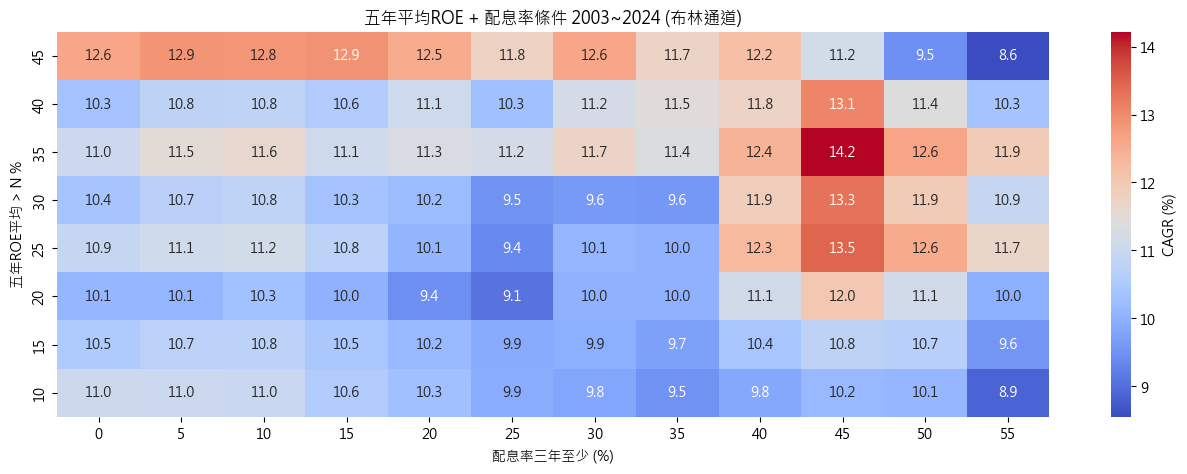

In [81]:

df = payout_roe_opts_comb_bol.selected_stock_count_analysis()

# Extracting 'N' and 'X' values manually based on the new format "配息_{N}%_ROE_{X}"
df['N'] = df.index.map(lambda x: x.split('_')[1].replace('%', ''))  # Extracting 配息率 (N)
df['X'] = df.index.map(lambda x: x.split('_')[-1])                  # Extracting ROE (X)

# Converting to numeric types
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Pivoting data to create a matrix for heatmap with ROE (X) as columns and 配息率 (N) as rows
heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# Plotting the heatmap with reversed Y-axis, in coolwarm color scheme, and custom labels
plt.figure(figsize=(16, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'CAGR (%)'}, 
            yticklabels=heatmap_data.index[:])
plt.xlabel("配息率三年至少 (%)")
plt.ylabel("五年ROE平均 > N %")
plt.title("五年平均ROE + 配息率條件 2003~2024 (布林通道)")
plt.show()

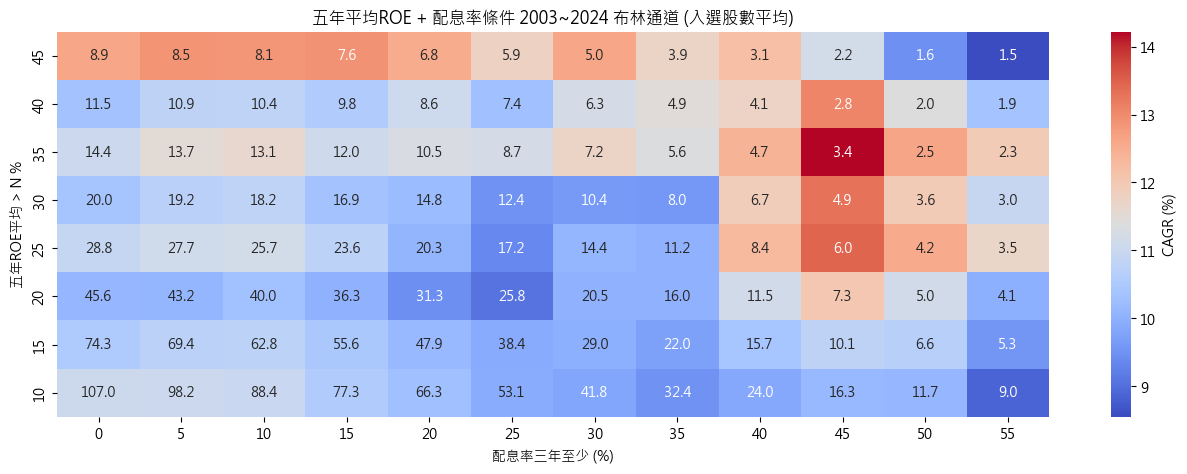

In [82]:
# Step 1: Extracting 配息率 (N) and ROE (X)
df['N'] = df.index.map(lambda x: x.split('_')[1].replace('%', ''))  # Extract 配息率 (N)
df['X'] = df.index.map(lambda x: x.split('_')[-1])                 # Extract ROE (X)

# Step 2: Converting to numeric types
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Step 3: Create matrices for heatmap data and annotations
heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)  # For colors
annotation_data = df.pivot(index="X", columns="N", values="入選股數平均").sort_index(ascending=False)  # For annotations

# Step 4: Plotting the heatmap
plt.figure(figsize=(16, 5))
sns.heatmap(
    heatmap_data,  # Data for colors
    annot=annotation_data,  # Data for annotations
    fmt=".1f",  # Format of annotations
    cmap="coolwarm",  # Color scheme
    cbar_kws={'label': 'CAGR (%)'},  # Colorbar label
    yticklabels=heatmap_data.index[:]  # Y-axis labels
)

# Step 5: Adding labels and title
plt.xlabel("配息率三年至少 (%)")
plt.ylabel("五年ROE平均 > N %")
plt.title("五年平均ROE + 配息率條件 2003~2024 布林通道 (入選股數平均)")
plt.show()

In [86]:
payout_roe_opts = {}

conds_without_roe_payout = rr_cond & netprofit_cond & listed_cond #[START_DATE:END_DATE]

for i in range(0, 56, 5):
    # for j in range(10, 13, 2):
    for k in range(10, 46, 5):

        # ROE n年平均 > k%
        df = roe.copy()
        # 提取index的月份
        df['month'] = df.index.month
        # 依據月份分組，對每個月份的每5年計算平均
        result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
        # 刪除用來group的欄位
        roe_rol_opt_df = result.drop(columns='month')
        roe_cond_opt = roe_rol_opt_df > (k / 100)

        payout_ratio_cond_opt = payout_ratio_rol >= (i/100)
        # per_entry_opt = (daily_pe.resample('M').last() < 12)

        opt_payout_PER_cond = roe_cond_opt & payout_ratio_cond_opt & conds_without_roe_payout
        

        payout_roe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE]) #[filtered_russell_1000_symbol]

        # payout_roe_opts[f'配息_{i}%_ROE_{k}'] = opt_payout_PER_cond[START_DATE:END_DATE]

        # payout_roe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & daily_pe_entry['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | daily_pe_exit['2009-3':])

payout_roe_opts_comb = sim_conditions(payout_roe_opts, resample='M', data=data)
payout_roe_opts_comb.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 96/96 [19:50<00:00, 12.40s/condition]


CAGR (%)  MDD (%)  入選股數平均   中位數  25%   75%  Min   Max
Strategy                                                            
配息_45%_ROE_40     15.35   -49.11    3.26   3.0  2.0   4.0  0.0   8.0
配息_0%_ROE_45      14.06   -50.41   11.83  13.0  8.0  15.0  3.0  22.0
配息_10%_ROE_45     13.94   -49.28   10.53  11.0  7.0  14.0  2.0  20.0
配息_5%_ROE_45      13.86   -50.38   10.96  12.0  7.0  14.0  3.0  20.0
配息_15%_ROE_45     13.79   -45.54    9.81  11.0  6.0  13.0  2.0  17.0
...                 ...      ...     ...   ...  ...   ...  ...   ...
配息_55%_ROE_15     10.21   -52.10    7.28   7.0  5.0   9.0  2.0  17.0
配息_50%_ROE_30      9.94   -67.93    4.72   5.0  2.0   6.0  1.0  13.0
配息_55%_ROE_35      9.93   -64.72    2.95   3.0  2.0   4.0  0.0   9.0
配息_55%_ROE_45      9.61   -58.73    1.77   2.0  1.0   3.0  0.0   5.0
配息_55%_ROE_30      8.99   -67.93    3.96   4.0  2.0   5.0  0.0  11.0

[96 rows x 8 columns]

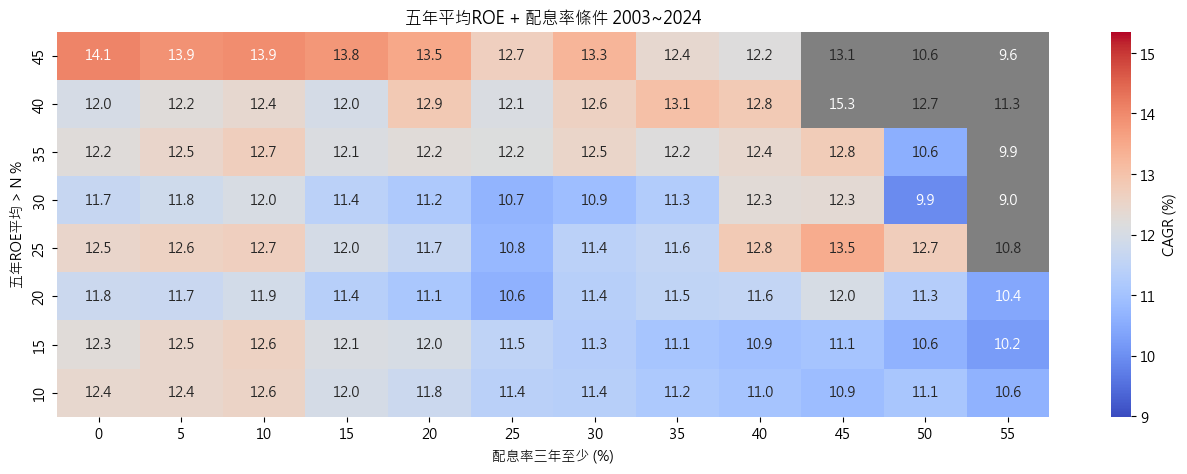

In [89]:
df = payout_roe_opts_comb.selected_stock_count_analysis()

# Extracting 'N' and 'X' values manually based on the new format "配息_{N}%_ROE_{X}"
df['N'] = df.index.map(lambda x: x.split('_')[1].replace('%', ''))  # Extracting 配息率 (N)
df['X'] = df.index.map(lambda x: x.split('_')[-1])                  # Extracting ROE (X)

# Converting to numeric types
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Pivoting data to create a matrix for heatmap with ROE (X) as columns and 配息率 (N) as rows
heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# Creating a mask for cells where 'Min' equals 0
min_mask_raw = df.pivot(index="X", columns="N", values="Min") == 0

# Align mask with heatmap_data (ensure same index and columns)
min_mask = min_mask_raw.reindex(index=heatmap_data.index, columns=heatmap_data.columns).fillna(False)

# Custom colormap: using "coolwarm" for normal data and "red" for highlighted cells
normal_cmap = sns.color_palette("coolwarm", as_cmap=True)
highlight_cmap = ListedColormap(["gray"])

# Plotting the heatmap
plt.figure(figsize=(16, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=normal_cmap, cbar_kws={'label': 'CAGR (%)'}, 
            yticklabels=heatmap_data.index[:])

# Overlay another heatmap for the highlighted cells
sns.heatmap(heatmap_data, mask=~min_mask, cmap=highlight_cmap, cbar=False, annot=False)

# Adding labels and title
plt.xlabel("配息率三年至少 (%)")
plt.ylabel("五年ROE平均 > N %")
plt.title("五年平均ROE + 配息率條件 2003~2024")
plt.show()

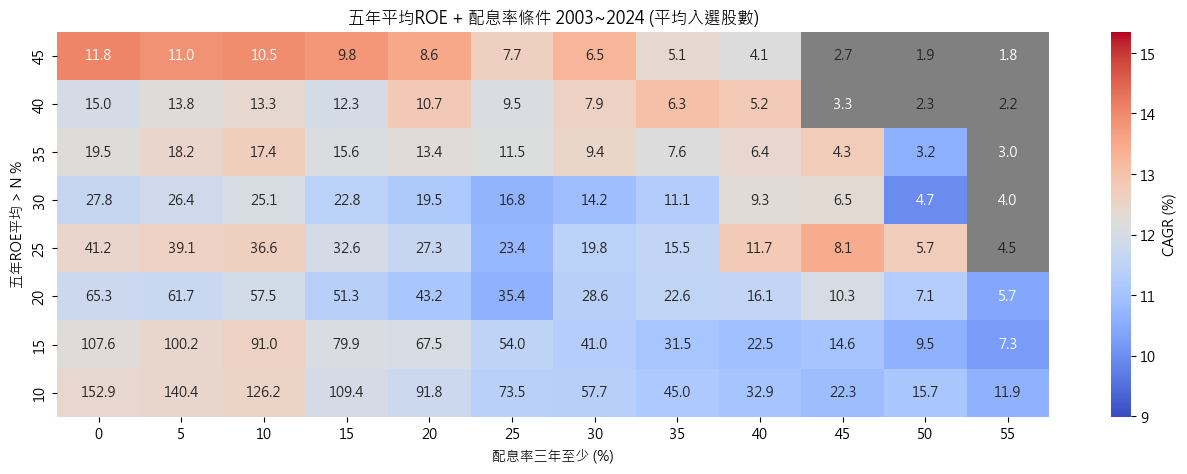

In [90]:
# Step 1: 創建用於顏色的矩陣 (CAGR %)
heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# Step 2: 創建用於顯示的數字矩陣 (入選股數平均)
annotation_data = df.pivot(index="X", columns="N", values="入選股數平均").sort_index(ascending=False)

# Step 3: 繪製熱圖
plt.figure(figsize=(16, 5))
sns.heatmap(
    heatmap_data,  # 用於顏色的值
    annot=annotation_data,  # 用於顯示數字的值
    fmt=".1f",  # 數字格式
    cmap=normal_cmap,  # 顏色映射
    cbar_kws={'label': 'CAGR (%)'},  # 色條標籤
    yticklabels=heatmap_data.index[:]  # Y 軸標籤
)

# Step 4: 添加灰色遮罩 (特殊條件處理，例如 Min=0)
sns.heatmap(
    heatmap_data,  # 使用相同的顏色數據
    mask=~min_mask,  # 遮罩條件
    cmap=highlight_cmap,  # 遮罩顏色
    cbar=False,  # 不顯示額外的色條
    annot=False  # 不覆蓋數字
)

# Step 5: 添加標籤與標題
plt.xlabel("配息率三年至少 (%)")
plt.ylabel("五年ROE平均 > N %")
plt.title("五年平均ROE + 配息率條件 2003~2024 (平均入選股數)")
plt.show()


---

## GDP 年增率

In [4]:
gdp_yoy_df = pd.read_csv('./macro_indicators/美國_GDP年增率_季.csv', encoding='cp950')

In [5]:
gdp_yoy_df = gdp_yoy_df.drop(columns=['證券代碼'])

實質GDP是每季數據，第一季的先期報告公布於四月底，其餘各季分別公佈於七月、十月與隔年的一月。 對於任何一季的報告，第一次修正報告稱為「初步」(preliminary)，第二次修正報告稱為「修正後」(revised)或「最終」(final)。 GDP是代表一個國家境內的全部經濟活動，不論誰擁有生產資產。

In [6]:
from pandas.tseries.offsets import MonthEnd, BDay

def get_end_of_month_date(row):
    year = int(row['年'])
    month = int(row['月'])
    if month == 3:
        target_date = pd.Timestamp(year, 4, 1) + MonthEnd(0)
    elif month == 6:
        target_date = pd.Timestamp(year, 7, 1) + MonthEnd(0)
    elif month == 9:
        target_date = pd.Timestamp(year, 10, 1) + MonthEnd(0)
    elif month == 12:
        target_date = pd.Timestamp(year + 1, 1, 1) + MonthEnd(0)
    else:
        return pd.NaT

    # 確保日期是非假日，如果是週末則取前一個工作日
    while target_date.weekday() >= 5:  # 5: Saturday, 6: Sunday
        target_date -= BDay(1)
    return target_date

gdp_yoy_df['date'] = gdp_yoy_df.apply(get_end_of_month_date, axis=1)
gdp_yoy_data = gdp_yoy_df.set_index('date', inplace=False)

In [7]:
gdp_yoy_data.drop(columns=['年', '月'], inplace=True)
gdp_yoy_data.rename(columns={'數值': 'gdp_yoy'}, inplace=True)

In [8]:
gdp_yoy_data

gdp_yoy
date               
2000-04-28   1.4571
2000-07-31   7.4878
2000-10-31   0.4082
2001-01-31   2.4110
2001-04-30  -1.3063
...             ...
2023-04-28   2.7956
2023-07-31   2.4504
2023-10-31   4.3552
2024-01-31   3.1928
2024-04-30   1.6283

[97 rows x 1 columns]

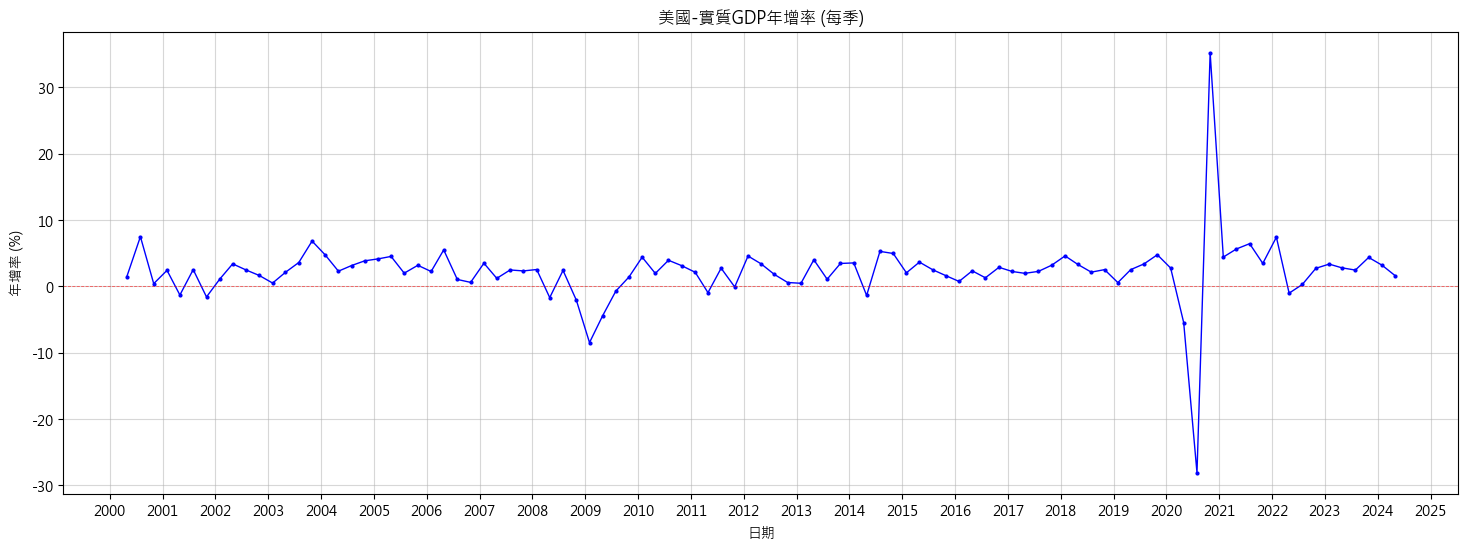

In [11]:
plt.figure(figsize=(18, 6))
plt.plot(gdp_yoy_data['gdp_yoy'], label='GDP年增率', color='b', linewidth=1, marker='o', markersize=2)
plt.title('美國-實質GDP年增率 (每季)')
plt.xlabel('日期')
plt.ylabel('年增率 (%)')
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.6, alpha=0.6)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.grid(alpha=0.5)
plt.show()